# Allen NLP playground
- for better understanding of the process

In [49]:
%load_ext autoreload
%autoreload 2


In [29]:
from collections import Counter, defaultdict


from allennlp.data.fields import TextField, LabelField, SequenceLabelField
from allennlp.data.token_indexers import SingleIdTokenIndexer
from allennlp.data.tokenizers import Token
from allennlp.data.vocabulary import Vocabulary
from allennlp.data.dataset_readers import DatasetReader
from allennlp.data.instance import Instance

from typing import Iterable

In [30]:
@DatasetReader.register('classification-tsv')
class ClassificationTsvReader(DatasetReader):
    def __init__(self):
        self.tokenizer = SpacyTokenizer()
        self.token_indexers = {'tokens': SingleIdTokenIndexer()}

    def _read(self, file_path: str) -> Iterable[Instance]:
        with open(file_path, 'r') as lines:
            for line in lines:
                text, label = line.strip().split('\t')
                text_field = TextField(self.tokenizer.tokenize(text),
                                       self.token_indexers)
                label_field = LabelField(label)
                fields = {'text': text_field, 'label': label_field}
                yield Instance(fields)

In [13]:
# To create fields, simply pass the data to constructor.
# NOTE: Don't worry about the token_indexers too much for now. We have a whole
# chapter on why TextFields are set up this way, and how they work.
tokens = [Token('The'), Token('best'), Token('movie'), Token('ever'), Token('!')]
token_indexers = {'tokens': SingleIdTokenIndexer()}
text_field = TextField(tokens, token_indexers=token_indexers)

label_field = LabelField('pos')

sequence_label_field = SequenceLabelField(
    ['DET', 'ADJ', 'NOUN', 'ADV', 'PUNKT'],
    text_field
)

In [14]:
# You can use print() fields to see their content
print(text_field)
print(label_field)
print(sequence_label_field)

TextField of length 5 with text: 
 		[The, best, movie, ever, !]
 		and TokenIndexers : {'tokens': 'SingleIdTokenIndexer'}
LabelField with label: pos in namespace: 'labels'.'
SequenceLabelField of length 5 with labels:
 		['DET', 'ADJ', 'NOUN', 'ADV', 'PUNKT']
 		in namespace: 'labels'.


In [15]:
# Many of the fields implement native python methods in intuitive ways
print(len(sequence_label_field))
print(label for label in sequence_label_field)

# Fields know how to create empty fields of the same type
print(text_field.empty_field())
print(label_field.empty_field())
print(sequence_label_field.empty_field())

5
<generator object <genexpr> at 0x7fd8ae9bd950>
TextField of length 0 with text: 
 		[]
 		and TokenIndexers : {'tokens': 'SingleIdTokenIndexer'}
LabelField with label: -1 in namespace: 'labels'.'
SequenceLabelField of length 0 with labels:
 		[]
 		in namespace: 'labels'.


In [23]:
# You can count vocabulary items in fields
counter = defaultdict(Counter)
text_field.count_vocab_items(counter)
print(counter)
print(counter["tokens"])
print()
label_field.count_vocab_items(counter)
print(counter)
print()
sequence_label_field.count_vocab_items(counter)
print(counter)

defaultdict(<class 'collections.Counter'>, {'tokens': Counter({'The': 1, 'best': 1, 'movie': 1, 'ever': 1, '!': 1})})
Counter({'The': 1, 'best': 1, 'movie': 1, 'ever': 1, '!': 1})

defaultdict(<class 'collections.Counter'>, {'tokens': Counter({'The': 1, 'best': 1, 'movie': 1, 'ever': 1, '!': 1}), 'labels': Counter({'pos': 1})})

defaultdict(<class 'collections.Counter'>, {'tokens': Counter({'The': 1, 'best': 1, 'movie': 1, 'ever': 1, '!': 1}), 'labels': Counter({'pos': 1, 'DET': 1, 'ADJ': 1, 'NOUN': 1, 'ADV': 1, 'PUNKT': 1})})


In [11]:
label_field.count_vocab_items(counter)
print(counter)

sequence_label_field.count_vocab_items(counter)
print(counter)

# Create Vocabulary for indexing fields
vocab = Vocabulary(counter)

# Fields know how to turn themselves into tensors
text_field.index(vocab)
# NOTE: in practice, we will batch together instances and use the maximum padding
# lengths, instead of getting them from a single instance.
# You can print this if you want to see what the padding_lengths dictionary looks
# like, but it can sometimes be a bit cryptic.
padding_lengths = text_field.get_padding_lengths()
print(text_field.as_tensor(padding_lengths))

label_field.index(vocab)
print(label_field.as_tensor(label_field.get_padding_lengths()))

sequence_label_field.index(vocab)
padding_lengths = sequence_label_field.get_padding_lengths()
print(sequence_label_field.as_tensor(padding_lengths))

# Fields know how to batch tensors
tensor1 = label_field.as_tensor(label_field.get_padding_lengths())

label_field2 = LabelField('pos')
label_field2.index(vocab)
tensor2 = label_field2.as_tensor(label_field2.get_padding_lengths())

batched_tensors = label_field.batch_tensors([tensor1, tensor2])
print(batched_tensors)

TextField of length 5 with text: 
 		[The, best, movie, ever, !]
 		and TokenIndexers : {'tokens': 'SingleIdTokenIndexer'}
LabelField with label: pos in namespace: 'labels'.'
SequenceLabelField of length 5 with labels:
 		['DET', 'ADJ', 'NOUN', 'ADV', 'PUNKT']
 		in namespace: 'labels'.
5
<generator object <genexpr> at 0x7fd766f206d0>
TextField of length 0 with text: 
 		[]
 		and TokenIndexers : {'tokens': 'SingleIdTokenIndexer'}
LabelField with label: -1 in namespace: 'labels'.'
SequenceLabelField of length 0 with labels:
 		[]
 		in namespace: 'labels'.
defaultdict(<class 'collections.Counter'>, {'tokens': Counter({'The': 1, 'best': 1, 'movie': 1, 'ever': 1, '!': 1})})
defaultdict(<class 'collections.Counter'>, {'tokens': Counter({'The': 1, 'best': 1, 'movie': 1, 'ever': 1, '!': 1}), 'labels': Counter({'pos': 1})})
defaultdict(<class 'collections.Counter'>, {'tokens': Counter({'The': 1, 'best': 1, 'movie': 1, 'ever': 1, '!': 1}), 'labels': Counter({'pos': 1, 'DET': 1, 'ADJ': 1, 'NOU

# Allen Predictors
- "https://storage.googleapis.com/allennlp-public-models/bert-base-srl-2020.03.24.tar.gz"
- "https://storage.googleapis.com/allennlp-public-models/biaffine-dependency-parser-ptb-2020.04.06.tar.gz"
- "https://storage.googleapis.com/allennlp-public-models/biaffine-dependency-parser-ud-2020.02.10.tar.gz"
- https://hal.archives-ouvertes.fr/hal-02786193/document
    - ud vs ptb

In [1]:
from allennlp.predictors.predictor import Predictor #

In [3]:
predictor_srl = Predictor.from_path("https://storage.googleapis.com/allennlp-public-models/bert-base-srl-2020.03.24.tar.gz")

In [7]:
type(predictor_srl.predict(
  sentence="Everyone thinks the news that is good enough will be released"
))

dict

In [10]:
predictor_dep = Predictor.from_path("https://storage.googleapis.com/allennlp-public-models/biaffine-dependency-parser-ptb-2020.04.06.tar.gz")

Did not use initialization regex that was passed: .*projection.*weight
Did not use initialization regex that was passed: .*bias_hh.*
Did not use initialization regex that was passed: .*weight_ih.*
Did not use initialization regex that was passed: .*weight_hh.*
Did not use initialization regex that was passed: .*bias_ih.*
Did not use initialization regex that was passed: .*projection.*bias


In [13]:
predictor_dep.predict(
  sentence="Everyone thinks the news that is good enough will be released"
)

{'arc_loss': 0.13308210670948029,
 'tag_loss': 0.16934286057949066,
 'loss': 0.30242496728897095,
 'words': ['Everyone',
  'thinks',
  'the',
  'news',
  'that',
  'is',
  'good',
  'enough',
  'will',
  'be',
  'released'],
 'pos': ['PRON',
  'VERB',
  'DET',
  'NOUN',
  'DET',
  'AUX',
  'ADJ',
  'ADV',
  'VERB',
  'AUX',
  'VERB'],
 'predicted_dependencies': ['nsubj',
  'root',
  'det',
  'dobj',
  'nsubj',
  'cop',
  'ccomp',
  'advmod',
  'aux',
  'auxpass',
  'ccomp'],
 'predicted_heads': [2, 0, 4, 2, 7, 7, 4, 7, 11, 11, 7],
 'hierplane_tree': {'text': 'Everyone thinks the news that is good enough will be released',
  'root': {'word': 'thinks',
   'nodeType': 'root',
   'attributes': ['VERB'],
   'link': 'root',
   'spans': [{'start': 9, 'end': 16}],
   'children': [{'word': 'Everyone',
     'nodeType': 'nsubj',
     'attributes': ['PRON'],
     'link': 'nsubj',
     'spans': [{'start': 0, 'end': 9}]},
    {'word': 'news',
     'nodeType': 'dobj',
     'attributes': ['NOUN'],
   

In [18]:
predictor_dep.predict(
  sentence="I've been deta's sd bsefore"
)["words"]

['I', "'ve", 'been', 'deta', "'s", 'sd', 'bsefore']

In [20]:
predictor_srl.predict(
  sentence="I've been deta's sd besfore"
)["words"]

['I', "'ve", 'been', 'deta', "'s", 'sd', 'besfore']

In [73]:
import do_parse
import config

In [74]:
type(predictor_srl)

allennlp_models.structured_prediction.predictors.srl.SemanticRoleLabelerPredictor

In [75]:
type(predictor_dep)

allennlp_models.structured_prediction.predictors.biaffine_dependency_parser.BiaffineDependencyParserPredictor

In [76]:
test10 = do_parse.process_file(data_file=config.TRAIN_FILE,
                      target_file=config.P_TRAIN_FILE,
                      srl_labeler_model=predictor_srl,
                      dep_parser_model=predictor_dep,
                      function_test=True,
                      force_exe=True)

  0%|          | 0/10 [00:00<?, ?it/s]

creating file /work/2020-IIS-NLU-internship/MNLI/data/MNLI_allen/pre_multinli_1.0_train.jsonl to save result
executing


100%|██████████| 10/10 [00:04<00:00,  2.23it/s]


In [77]:
test10[0][config.hf]["dep"]

{'arc_loss': 0.48571792244911194,
 'tag_loss': 0.4315148890018463,
 'loss': 0.9172328114509583,
 'words': ['Product',
  'and',
  'geography',
  'are',
  'what',
  'make',
  'cream',
  'skimming',
  'work',
  '.'],
 'pos': ['NOUN',
  'CCONJ',
  'NOUN',
  'AUX',
  'PRON',
  'VERB',
  'NOUN',
  'VERB',
  'NOUN',
  'PUNCT'],
 'predicted_dependencies': ['nsubj',
  'prep',
  'dobj',
  'root',
  'nsubj',
  'ccomp',
  'nn',
  'nsubj',
  'xcomp',
  'dep'],
 'predicted_heads': [4, 1, 1, 0, 6, 4, 8, 9, 6, 4],
 'hierplane_tree': {'text': 'Product and geography are what make cream skimming work .',
  'root': {'word': 'are',
   'nodeType': 'root',
   'attributes': ['AUX'],
   'link': 'root',
   'spans': [{'start': 22, 'end': 26}],
   'children': [{'word': 'Product',
     'nodeType': 'nsubj',
     'attributes': ['NOUN'],
     'link': 'nsubj',
     'spans': [{'start': 0, 'end': 8}],
     'children': [{'word': 'and',
       'nodeType': 'prep',
       'attributes': ['CCONJ'],
       'link': 'prep',
    

In [78]:
with open(config.TRAIN_FILE) as fo:
    line = fo.readline()
    print(line)

{"annotator_labels": ["neutral"], "genre": "government", "gold_label": "neutral", "pairID": "31193n", "promptID": "31193", "sentence1": "Conceptually cream skimming has two basic dimensions - product and geography.", "sentence1_binary_parse": "( ( Conceptually ( cream skimming ) ) ( ( has ( ( ( two ( basic dimensions ) ) - ) ( ( product and ) geography ) ) ) . ) )", "sentence1_parse": "(ROOT (S (NP (JJ Conceptually) (NN cream) (NN skimming)) (VP (VBZ has) (NP (NP (CD two) (JJ basic) (NNS dimensions)) (: -) (NP (NN product) (CC and) (NN geography)))) (. .)))", "sentence2": "Product and geography are what make cream skimming work. ", "sentence2_binary_parse": "( ( ( Product and ) geography ) ( ( are ( what ( make ( cream ( skimming work ) ) ) ) ) . ) )", "sentence2_parse": "(ROOT (S (NP (NN Product) (CC and) (NN geography)) (VP (VBP are) (SBAR (WHNP (WP what)) (S (VP (VBP make) (NP (NP (NN cream)) (VP (VBG skimming) (NP (NN work)))))))) (. .)))"}



In [80]:
test10 = do_parse.process_file(data_file=config.TRAIN_FILE,
                      target_file=config.P_DEVELOPMENT_FILE,
                      srl_labeler_model=predictor_srl,
                      dep_parser_model=predictor_dep,
                      function_test=True,
                      force_exe=False)

  0%|          | 0/10 [00:00<?, ?it/s]

creating file /work/2020-IIS-NLU-internship/MNLI/data/MNLI_allen/for_development.jsonl to save result
executing


100%|██████████| 10/10 [00:05<00:00,  1.99it/s]


In [82]:
srl_gpu = Predictor.from_path("https://storage.googleapis.com/allennlp-public-models/bert-base-srl-2020.03.24.tar.gz", cuda_device=0)
dep_gpu = Predictor.from_path(config.DEP_PARSER_MODEL, cuda_device=0)

2020-08-10 13:40:52 WARNING: Did not use initialization regex that was passed: .*projection.*weight
2020-08-10 13:40:52 WARNING: Did not use initialization regex that was passed: .*bias_hh.*
2020-08-10 13:40:52 WARNING: Did not use initialization regex that was passed: .*weight_ih.*
2020-08-10 13:40:52 WARNING: Did not use initialization regex that was passed: .*weight_hh.*
2020-08-10 13:40:52 WARNING: Did not use initialization regex that was passed: .*bias_ih.*
2020-08-10 13:40:52 WARNING: Did not use initialization regex that was passed: .*projection.*bias


In [83]:
test10 = do_parse.process_file(data_file=config.TRAIN_FILE,
                      target_file=config.P_DEVELOPMENT_FILE,
                      srl_labeler_model=srl_gpu,
                      dep_parser_model=dep_gpu,
                      function_test=True,
                      force_exe=True)

  0%|          | 0/10 [00:00<?, ?it/s]

creating file /work/2020-IIS-NLU-internship/MNLI/data/MNLI_allen/for_development.jsonl to save result
executing


100%|██████████| 10/10 [00:03<00:00,  2.85it/s]


In [111]:
exp = "Allen uses a pen. And Jack uses a pencil made in China"

In [112]:
doc = dep_gpu.predict(sentence=exp)

In [113]:
doc.keys()

dict_keys(['arc_loss', 'tag_loss', 'loss', 'words', 'pos', 'predicted_dependencies', 'predicted_heads', 'hierplane_tree'])

In [114]:
len(doc["predicted_dependencies"])

13

In [115]:
len(doc["predicted_heads"])

13

In [116]:
len(doc["words"])

13

In [143]:
import utils

In [146]:
utils.doc2graph_allennlp(doc)

Data(edge_attr=[13], edge_index=[2, 13], node_attr=[14], x=[13])

In [147]:
G = utils.text2graph_allennlp(exp, predictor_dep)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
[(1, 2), (2, 0), (3, 4), (4, 5), (5, 2), (6, 2), (7, 8), (8, 6), (9, 10), (10, 8), (11, 10), (12, 11), (13, 12)]


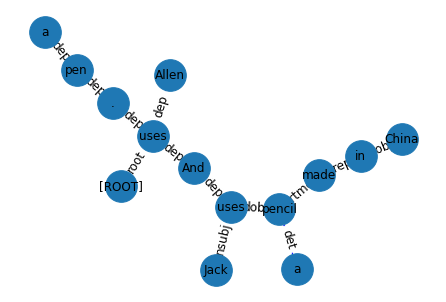

In [148]:
utils.draw(G, save_img_file="allennlp_fail_sentences")

In [149]:
anli_exp = "Eme 15 is the self-titled debut studio album by Mexican-Argentine pop band, Eme 15. The album was released in Mexico and Latin America on June 26, 2012 through Warner Music M\u00e9xico, and features songs from the Nickelodeon Latin America and Televisa musical television series, Miss XV."

In [170]:
g1 = utils.text2graph(anli_exp, parser=predictor_dep, parser_name="allennlp")

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56]
[(1, 3), (2, 1), (3, 0), (4, 9), (5, 9), (6, 9), (7, 9), (8, 9), (9, 3), (10, 3), (11, 10), (12, 11), (13, 12), (14, 12), (15, 12), (16, 12), (17, 12), (18, 17), (19, 20), (20, 22), (21, 22), (22, 17), (23, 24), (24, 17), (25, 24), (26, 25), (27, 26), (28, 26), (29, 25), (30, 24), (31, 30), (32, 31), (33, 24), (34, 24), (35, 34), (36, 37), (37, 35), (38, 35), (39, 34), (40, 39), (41, 39), (42, 41), (43, 42), (44, 52), (45, 52), (46, 47), (47, 52), (48, 52), (49, 52), (50, 52), (51, 52), (52, 43), (53, 52), (54, 55), (55, 53), (56, 54)]


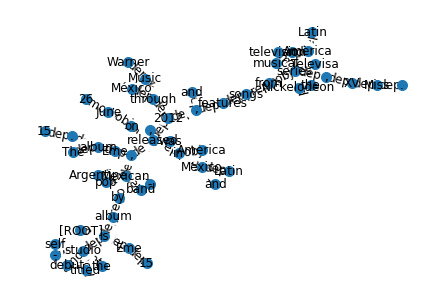

In [171]:
utils.draw(g1, node_size=100, save_img_file="allennlp-parser-anli-exp.png")

In [151]:
import stanza
from stanza.models.common.doc import Document

In [152]:
nlp = stanza.Pipeline(lang='en', processors='tokenize,mwt,pos,lemma,depparse')

2020-08-10 15:45:08 WARNING: Can not find mwt: default from official model list. Ignoring it.
2020-08-10 15:45:08 INFO: Loading these models for language: en (English):
| Processor | Package |
-----------------------
| tokenize  | ewt     |
| pos       | ewt     |
| lemma     | ewt     |
| depparse  | ewt     |

2020-08-10 15:45:08 INFO: Use device: gpu
2020-08-10 15:45:08 INFO: Loading: tokenize
2020-08-10 15:45:08 INFO: Loading: pos
2020-08-10 15:45:09 INFO: Loading: lemma
2020-08-10 15:45:09 INFO: Loading: depparse
2020-08-10 15:45:11 INFO: Done loading processors!


In [153]:
type(nlp)

stanza.pipeline.core.Pipeline

In [168]:
g2 = utils.text2graph(anli_exp, parser=nlp, parser_name="Stanza")

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57]
[(0, 10), (0, 21), (1, 2), (7, 5), (7, 6), (9, 8), (10, 1), (10, 3), (10, 4), (10, 7), (10, 9), (10, 16), (10, 20), (14, 12), (14, 13), (16, 11), (16, 14), (16, 15), (16, 17), (16, 18), (18, 19), (21, 25), (23, 22), (25, 23), (25, 24), (25, 27), (25, 32), (25, 39), (25, 42), (25, 57), (27, 26), (27, 30), (30, 28), (30, 29), (32, 31), (32, 33), (32, 34), (32, 35), (39, 36), (39, 37), (39, 38), (42, 40), (42, 41), (42, 43), (43, 48), (48, 44), (48, 45), (48, 46), (48, 47), (48, 53), (53, 49), (53, 50), (53, 51), (53, 52), (53, 54), (53, 56), (56, 55)]


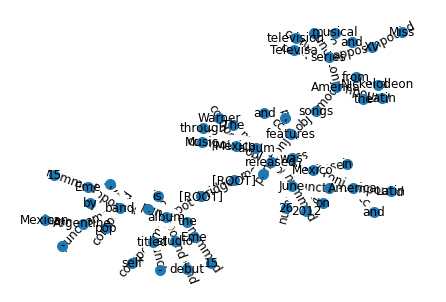

In [169]:
utils.draw(g2, node_size=100, save_img_file="stanza-parser-anli-exp.png")